<a href="https://www.kaggle.com/code/aleksanderprudnik/synthetic-oct-glaucoma-dataset-notebook?scriptVersionId=224670748" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cell 1: Import Libraries and Check Environment

In [1]:
import numpy as np
import h5py
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

print("NumPy version:", np.__version__)
print("h5py version:", h5py.__version__)
print("Working directory:", os.getcwd())
print("Input directory contents:", os.listdir('/kaggle/input'))
print("Output directory:", os.listdir('/kaggle/working'))

NumPy version: 1.26.4
h5py version: 3.12.1
Working directory: /kaggle/working
Input directory contents: ['synthetic-oct-glaucoma-dataset']
Output directory: ['__notebook__.ipynb']


# Cell 2: Define Full SyntheticDataGenerator Class

In [2]:
class SyntheticDataGenerator:
    def __init__(self, input_shape=(224, 224, 1)):
        self.input_shape = input_shape
        self.n_classes = 5
        self.scaler = StandardScaler()

    def generate_cup_disc_ratio(self, n_samples):
        base = np.zeros((n_samples, self.input_shape[0], self.input_shape[1]))
        cdr_ranges = {
            'normal': (0.1, 0.4), 'borderline': (0.4, 0.6),
            'early': (0.6, 0.7), 'advanced': (0.7, 0.9)
        }
        for i in range(n_samples):
            condition = np.random.choice(list(cdr_ranges.keys()))
            cdr = np.random.uniform(*cdr_ranges[condition])
            center_x, center_y = self.input_shape[0] // 2, self.input_shape[1] // 2
            y, x = np.ogrid[-center_x:self.input_shape[0]-center_x, -center_y:self.input_shape[1]-center_y]
            disc_radius = 80
            disc_mask = x*x + y*y <= disc_radius*disc_radius
            cup_radius = int(disc_radius * cdr)
            cup_mask = x*x + y*y <= cup_radius*cup_radius
            base[i][disc_mask] = 0.8
            base[i][cup_mask] = 0.2
            rim_mask = disc_mask & ~cup_mask
            dist = np.sqrt(x*x + y*y)
            rim_gradient = np.clip(1 - (dist - cup_radius)/(disc_radius - cup_radius), 0, 1)
            base[i][rim_mask] = 0.8 + 0.2 * rim_gradient[rim_mask]
            if condition in ['early', 'advanced']:
                vertical_stretch = np.random.uniform(1.1, 1.3)
                y = y / vertical_stretch
                cup_mask = x*x + y*y <= cup_radius*cup_radius
                base[i][cup_mask] = 0.2
            if condition in ['early', 'advanced']:
                vessel_angle = np.random.uniform(-np.pi/6, np.pi/6)
                vessel_mask = (np.abs(np.arctan2(y, x) - vessel_angle) < 0.1) & disc_mask
                base[i][vessel_mask] = 0.6
            noise = np.random.normal(0, 0.05, self.input_shape[:2])
            base[i] += noise * disc_mask
            base[i] = gaussian_filter(base[i], sigma=1)
        return base

    def generate_rim_data(self, n_samples):
        base = np.zeros((n_samples, self.input_shape[0], self.input_shape[1]))
        rim_ranges = {
            'normal': (1.6, 2.0), 'borderline': (1.3, 1.59),
            'early_loss': (1.0, 1.29), 'advanced': (0.6, 0.99)
        }
        isnt_ratios = {
            'inferior': (1.0, 1.2), 'superior': (0.9, 1.1),
            'nasal': (0.7, 0.9), 'temporal': (0.5, 0.7)
        }
        for i in range(n_samples):
            condition = np.random.choice(list(rim_ranges.keys()))
            rim_area = np.random.uniform(*rim_ranges[condition])
            center_x, center_y = self.input_shape[0] // 2, self.input_shape[1] // 2
            radius = int(np.sqrt(rim_area/np.pi) * 50)
            y, x = np.ogrid[-center_x:self.input_shape[0]-center_x, -center_y:self.input_shape[1]-center_y]
            circle_mask = x*x + y*y <= radius*radius
            angles = np.arctan2(y, x)
            base[i][~circle_mask] = 0
            for sector, (min_ratio, max_ratio) in isnt_ratios.items():
                if condition in ['early_loss', 'advanced']:
                    min_ratio *= 0.6
                    max_ratio *= 0.7
                thickness = np.random.uniform(min_ratio, max_ratio)
                if sector == 'inferior':
                    sector_mask = (angles < -np.pi/4) & (angles > -3*np.pi/4) & circle_mask
                    if condition == 'advanced':
                        thickness *= 0.5
                elif sector == 'superior':
                    sector_mask = (angles > np.pi/4) & (angles < 3*np.pi/4) & circle_mask
                    if condition == 'early_loss':
                        thickness *= 0.7
                elif sector == 'nasal':
                    sector_mask = (np.abs(angles) < np.pi/4) & circle_mask
                else:
                    sector_mask = (np.abs(angles) > 3*np.pi/4) & circle_mask
                    if condition in ['early_loss', 'advanced']:
                        thickness *= 0.4
                radial_dist = np.sqrt(x*x + y*y)
                gradient = np.clip(1 - (radial_dist / radius), 0, 1)
                sector_values = thickness * gradient
                base[i][sector_mask] = sector_values[sector_mask]
            if condition in ['early_loss', 'advanced']:
                notch_angle = np.random.uniform(-np.pi, np.pi)
                notch_mask = (np.abs(angles - notch_angle) < 0.2)
                base[i][notch_mask] *= 0.5
            if condition == 'advanced':
                base[i] *= 0.7
            age_factor = np.random.uniform(0.9, 1.0)
            base[i] *= age_factor
            base[i] = gaussian_filter(base[i], sigma=1)
        return base

    def generate_rnfl_patterns(self, n_samples):
        base = np.zeros((n_samples, self.input_shape[0], self.input_shape[1]))
        thickness_ranges = {
            'normal': (90, 105), 'early_loss': (70, 89),
            'moderate_loss': (50, 69), 'severe_loss': (30, 49)
        }
        tsnit_profile = {
            'temporal': (65, 75), 'superior': (120, 130),
            'nasal': (75, 85), 'inferior': (120, 130)
        }
        defect_patterns = ['wedge', 'diffuse', 'focal', None]
        for i in range(n_samples):
            pattern_type = np.random.choice(list(thickness_ranges.keys()))
            base_thickness = np.random.randint(*thickness_ranges[pattern_type])
            center_x, center_y = self.input_shape[0] // 2, self.input_shape[1] // 2
            radius = min(center_x, center_y) - 10
            y, x = np.ogrid[-center_x:self.input_shape[0]-center_x, -center_y:self.input_shape[1]-center_y]
            circle_mask = x*x + y*y <= radius*radius
            angles = np.arctan2(y, x)
            base[i] = np.zeros(self.input_shape[:2])
            noise = np.random.normal(0, 0.05, self.input_shape[:2])
            base[i] += noise
            for theta in np.linspace(0, 2*np.pi, 360):
                r_noise = np.random.normal(0, 0.1)
                r = radius * (1 + r_noise)
                y_coord = int(center_y + r * np.sin(theta))
                x_coord = int(center_x + r * np.cos(theta))
                if 0 <= y_coord < self.input_shape[0] and 0 <= x_coord < self.input_shape[1]:
                    base[i][y_coord, x_coord] = base_thickness
            base[i] = gaussian_filter(base[i], sigma=2)
            if pattern_type != 'severe_loss':
                superior_mask = (angles > 0) & (angles < np.pi/2) & circle_mask
                inferior_mask = (angles < 0) & (angles > -np.pi/2) & circle_mask
                temporal_mask = (np.abs(angles) > 3*np.pi/4) & circle_mask
                nasal_mask = (np.abs(angles) < np.pi/4) & circle_mask
                base[i][superior_mask] *= np.mean(tsnit_profile['superior'])/base_thickness
                base[i][inferior_mask] *= np.mean(tsnit_profile['inferior'])/base_thickness
                base[i][temporal_mask] *= np.mean(tsnit_profile['temporal'])/base_thickness
                base[i][nasal_mask] *= np.mean(tsnit_profile['nasal'])/base_thickness
            for sector, (min_val, max_val) in tsnit_profile.items():
                if sector == 'temporal':
                    sector_mask = (np.abs(angles) > 2.6) & circle_mask
                elif sector == 'superior':
                    sector_mask = (angles > 0.5) & (angles < 1.5) & circle_mask
                elif sector == 'nasal':
                    sector_mask = (np.abs(angles) < 0.5) & circle_mask
                else:
                    sector_mask = (angles < -0.5) & (angles > -1.5) & circle_mask
                sector_thickness = np.random.uniform(min_val, max_val)
                base[i][sector_mask] = sector_thickness
            defect = np.random.choice(defect_patterns)
            if defect == 'wedge':
                start_angle = np.random.uniform(-np.pi, np.pi)
                wedge_mask = (np.abs(angles - start_angle) < 0.3) & circle_mask
                base[i][wedge_mask] *= 0.6
            elif defect == 'diffuse':
                base[i][circle_mask] *= 0.8
            elif defect == 'focal':
                focal_angle = np.random.uniform(-np.pi, np.pi)
                focal_mask = (np.abs(angles - focal_angle) < 0.1) & circle_mask
                base[i][focal_mask] *= 0.5
            vessels = [(0.8, 0.1), (2.3, 0.1), (-0.8, 0.1), (-2.3, 0.1)]
            for angle, width in vessels:
                vessel_mask = (np.abs(angles - angle) < width) & circle_mask
                base[i][vessel_mask] *= 0.85
            if pattern_type == 'normal':
                age_factor = np.random.uniform(0.9, 1.0)
                base[i] *= age_factor
        return base

    def generate_juxtapapillary_rnfl(self, n_samples):
        base = np.zeros((n_samples, self.input_shape[0], self.input_shape[1]))
        thickness_ranges = {
            'normal': (90, 120), 'early_loss': (70, 89),
            'moderate_loss': (50, 69), 'advanced_loss': (30, 49)
        }
        sector_ratios = {
            'temporal': (0.7, 0.8), 'superior': (1.2, 1.4),
            'nasal': (0.8, 0.9), 'inferior': (1.2, 1.4)
        }
        for i in range(n_samples):
            condition = np.random.choice(list(thickness_ranges.keys()))
            base_thickness = np.random.uniform(*thickness_ranges[condition])
            center_x, center_y = self.input_shape[0] // 2, self.input_shape[1] // 2
            radius = int(min(center_x, center_y) * 0.7)
            y, x = np.ogrid[-center_x:self.input_shape[0]-center_x, -center_y:self.input_shape[1]-center_y]
            angles = np.arctan2(y, x)
            circle_mask = x*x + y*y <= radius*radius
            for sector, (min_ratio, max_ratio) in sector_ratios.items():
                ratio = np.random.uniform(min_ratio, max_ratio)
                if condition != 'normal':
                    ratio *= 0.8
                if sector == 'temporal':
                    sector_mask = (np.abs(angles) > 2.8) & circle_mask
                elif sector == 'superior':
                    sector_mask = (angles > 0.4) & (angles < 1.6) & circle_mask
                elif sector == 'nasal':
                    sector_mask = (np.abs(angles) < 0.4) & circle_mask
                else:
                    sector_mask = (angles < -0.4) & (angles > -1.6) & circle_mask
                sector_thickness = base_thickness * ratio
                base[i][sector_mask] = sector_thickness
            if condition in ['moderate_loss', 'advanced_loss']:
                defect_angle = np.random.uniform(-np.pi, np.pi)
                wedge_mask = (np.abs(angles - defect_angle) < 0.3) & circle_mask
                base[i][wedge_mask] *= 0.5
            vessel_locations = [(0.7, 0.1), (-0.7, 0.1)]
            for angle, width in vessel_locations:
                vessel_mask = (np.abs(angles - angle) < width) & circle_mask
                base[i][vessel_mask] *= 0.9
            if condition == 'normal':
                age_factor = np.random.uniform(0.9, 1.0)
                base[i] *= age_factor
            noise = np.random.normal(0, 0.05, self.input_shape[:2])
            base[i] += noise * circle_mask
            base[i] = gaussian_filter(base[i], sigma=1)
        return base

    def generate_sheath_data(self, n_samples):
        base = np.zeros((n_samples, self.input_shape[0], self.input_shape[1]))
        sheath_ranges = {
            'normal': (5.5, 6.0), 'borderline': (6.0, 6.5), 'elevated': (6.5, 7.5)
        }
        for i in range(n_samples):
            condition = np.random.choice(list(sheath_ranges.keys()))
            diameter = np.random.uniform(*sheath_ranges[condition])
            center_x, center_y = self.input_shape[0] // 2, self.input_shape[1] // 2
            y, x = np.ogrid[-center_x:self.input_shape[0]-center_x, -center_y:self.input_shape[1]-center_y]
            radius = int(diameter * 20)
            sheath_mask = x*x + y*y <= radius*radius
            nerve_radius = int(radius * 0.4)
            nerve_mask = x*x + y*y <= nerve_radius*nerve_radius
            base[i][sheath_mask] = 0.8
            base[i][nerve_mask] = 0.3
            measurement_point = np.zeros_like(base[i])
            point_mask = (np.abs(x - 60) < 5) & (np.abs(y) < 5)
            measurement_point[point_mask] = 1.0
            base[i] += measurement_point * sheath_mask
            if condition == 'elevated':
                base[i][sheath_mask & ~nerve_mask] *= 1.2
            age_factor = np.random.uniform(0.9, 1.0)
            base[i] *= age_factor
            noise = np.random.normal(0, 0.05, self.input_shape[:2])
            base[i] += noise * sheath_mask
            base[i] = gaussian_filter(base[i], sigma=1)
        return base

    def generate_macular_thickness(self, n_samples):
        base = np.zeros((n_samples, self.input_shape[0], self.input_shape[1]))
        thickness_ranges = {
            'normal': {'center': (250, 310), 'gcipl': (70, 85), 'outer_retina': (170, 190)},
            'early_glaucoma': {'center': (245, 305), 'gcipl': (60, 75), 'outer_retina': (165, 185)},
            'advanced_glaucoma': {'center': (240, 300), 'gcipl': (45, 65), 'outer_retina': (160, 180)}
        }
        zones = {'central': 0.5, 'inner': 1.5, 'outer': 3.0}
        for i in range(n_samples):
            condition = np.random.choice(list(thickness_ranges.keys()))
            center_x, center_y = self.input_shape[0] // 2, self.input_shape[1] // 2
            y, x = np.ogrid[-center_x:self.input_shape[0]-center_x, -center_y:self.input_shape[1]-center_y]
            r = np.sqrt(x*x + y*y)
            scale = min(self.input_shape[0], self.input_shape[1]) / (2 * zones['outer'])
            foveal_radius = zones['central'] * scale
            base[i] = thickness_ranges[condition]['center'][1] * np.exp(-0.5 * (r/(foveal_radius/2))**2)
            gcipl_range = thickness_ranges[condition]['gcipl']
            gcipl_mask = (r > foveal_radius) & (r < zones['outer'] * scale)
            base[i][gcipl_mask] += np.random.uniform(*gcipl_range)
            if condition != 'normal':
                angles = np.arctan2(y, x)
                superior_mask = (angles > 0) & gcipl_mask
                base[i][superior_mask] *= 0.85
            age_factor = np.random.uniform(0.9, 1.0)
            base[i] *= age_factor
            noise = np.random.normal(0, 2, self.input_shape[:2])
            base[i] += noise
            base[i] = gaussian_filter(base[i], sigma=1)
            base[i] = np.clip(base[i], 150, 350)
        return base

    def generate_dataset(self, n_samples):
        rnfl_data = self.generate_rnfl_patterns(n_samples)
        cup_disc_data = self.generate_cup_disc_ratio(n_samples)
        rim_data = self.generate_rim_data(n_samples)
        juxta_data = self.generate_juxtapapillary_rnfl(n_samples)
        sheath_data = self.generate_sheath_data(n_samples)
        macular_data = self.generate_macular_thickness(n_samples)
        labels = np.random.randint(0, self.n_classes, n_samples)
        labels_onehot = to_categorical(labels, self.n_classes)
        return {
            'rnfl_input': rnfl_data, 'cup_disc_input': cup_disc_data,
            'rim_input': rim_data, 'juxta_input': juxta_data,
            'sheath_input': sheath_data, 'macular_input': macular_data
        }, labels_onehot

# Cell 3: Generate and Save Dataset Cell 3: Generate and Save Dataset

In [3]:
generator = SyntheticDataGenerator()
n_samples = 100  # Adjust based on memory constraints
data, labels = generator.generate_dataset(n_samples)

# Save to HDF5 file
output_path = '/kaggle/working/synthetic_glaucoma_oct.h5'
with h5py.File(output_path, 'w') as f:
    for key, value in data.items():
        f.create_dataset(key, data=value, compression='gzip')
    f.create_dataset('labels', data=labels, compression='gzip')
print(f"Dataset saved to {output_path}")

Dataset saved to /kaggle/working/synthetic_glaucoma_oct.h5


# Cell 4: Visualize Sample Data

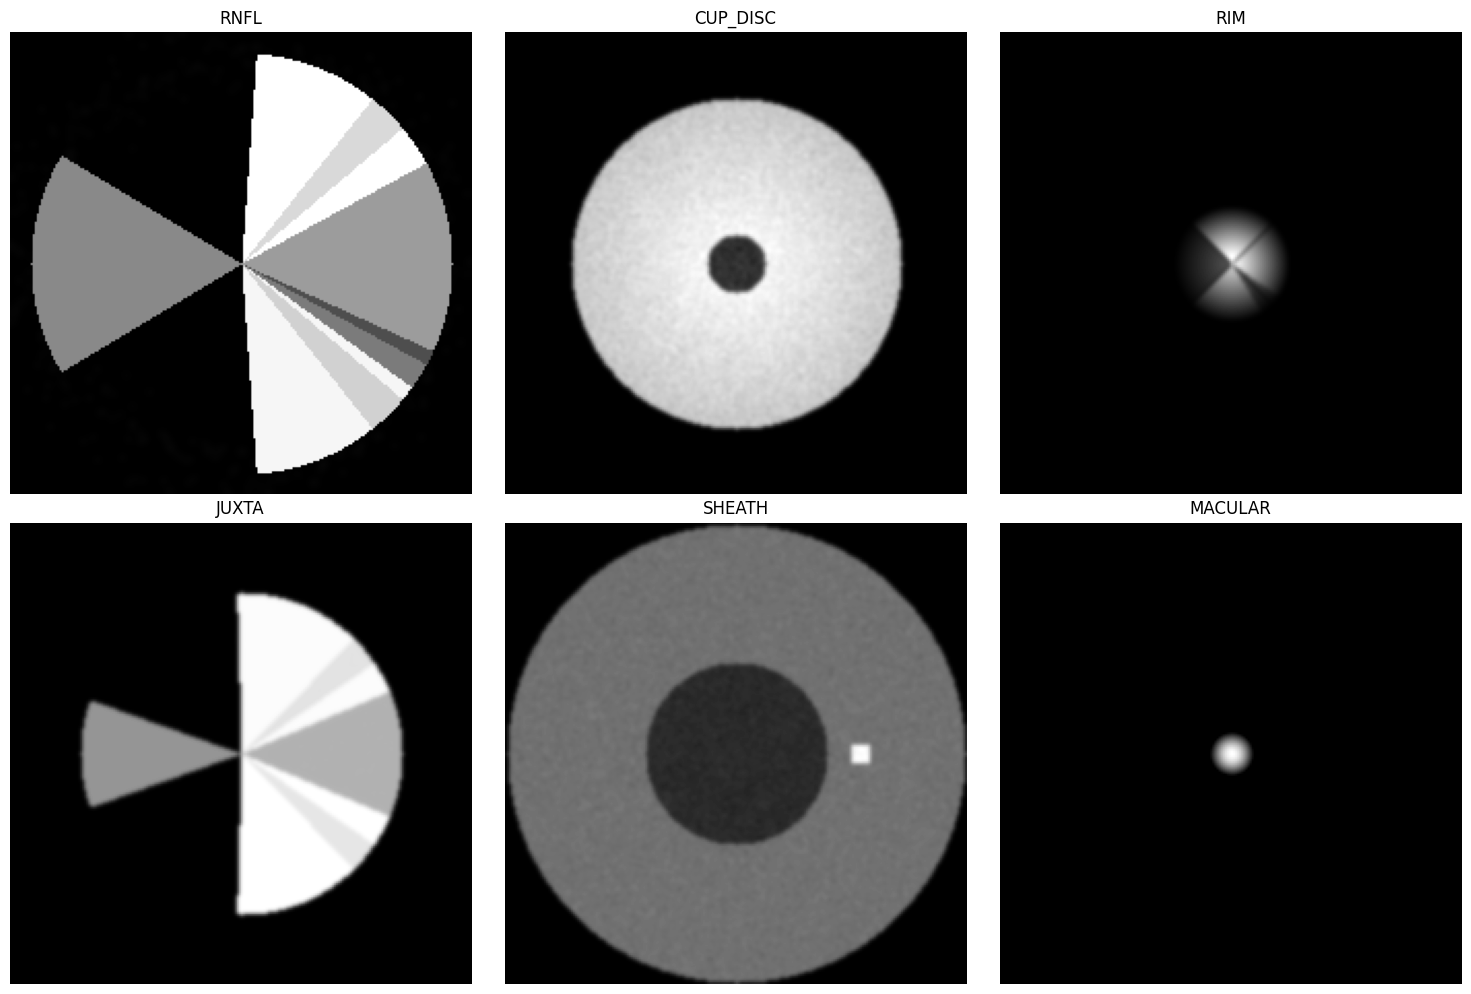

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = list(data.keys())
for i, ax in enumerate(axes.flat):
    ax.imshow(data[features[i]][0], cmap='gray')
    ax.set_title(features[i].replace('_input', '').upper())
    ax.axis('off')
plt.tight_layout()
plt.show()

# Cell 5: Verify HDF5 File

In [5]:
with h5py.File(output_path, 'r') as f:
    print("HDF5 contents:", list(f.keys()))
    for key in f.keys():
        print(f"{key} shape: {f[key].shape}")

HDF5 contents: ['cup_disc_input', 'juxta_input', 'labels', 'macular_input', 'rim_input', 'rnfl_input', 'sheath_input']
cup_disc_input shape: (100, 224, 224)
juxta_input shape: (100, 224, 224)
labels shape: (100, 5)
macular_input shape: (100, 224, 224)
rim_input shape: (100, 224, 224)
rnfl_input shape: (100, 224, 224)
sheath_input shape: (100, 224, 224)
